## Aprendizagem Automática 2023/2024
#### 3rd Home Assignment - Group 8
Rute Patuleia, 51780 | Tiago Assis, 62609 | João Lobato, 62611 | Miguel Landum, 35019

#### Introduction

In [1]:
# Importing all necessary libraries
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, Normalizer
from sklearn.tree import DecisionTreeRegressor
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr

In [2]:
# Defining functions to calculate and print out model statistics
def get_stats(y_test, preds):   
    rve = explained_variance_score(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    corr, pval = pearsonr(y_test, preds)
    maxe = max_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    stats = rve, rmse, corr, pval, maxe, mae
    return stats

def print_stats(stats):
    print("These are the statistics:")
    print("The RVE is:", stats[0])
    print("The rmse is:", stats[1])
    print("The Correlation Score is: %6.4f (p-value=%e)\n"%(stats[2], stats[3]))
    print("The Maximum Error is:", stats[4])
    print("The Mean Absolute Error is:", stats[5])

In [28]:
# Loading the dataset
X_TRAIN, X_IVS, y_TRAIN, col_names = pickle.load(open("drd2_data.pickle", "rb"))

In [29]:
# Converting to DataFrame
X_TRAIN = pd.DataFrame(X_TRAIN, columns=col_names)
y_TRAIN = pd.Series(y_TRAIN, name="molecular_activity")
X_IVS = pd.DataFrame(X_IVS, columns=col_names)

In [206]:
X_TRAIN.head()

,D00,D01,D02,D03,D04,D05,D06,D07,D08,D09,...,FP2079,FP2080,FP2081,FP2082,FP2083,FP2084,FP2085,FP2086,FP2087,FP2088
0,541.280138,541.656,10.0,1.0,8.0,1.0,10.0,40.0,75.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,426.197714,426.582,5.0,1.0,9.0,1.0,4.0,30.0,60.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,348.183778,348.446,4.0,0.0,3.0,0.0,3.0,26.0,50.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1455.763803,1456.831,27.0,19.0,23.0,17.0,16.0,105.0,206.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,387.151368,387.886,4.0,0.0,4.0,0.0,4.0,27.0,50.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
y_TRAIN.head()

0    0.654947
1    0.649995
2    0.154947
3    0.616176
4    0.359725
Name: molecular_activity, dtype: float64

In [6]:
# Checking number of rows and columns
print(X_TRAIN.shape)
print(y_TRAIN.shape)
print(X_IVS.shape)

(7337, 2132)
(7337,)
(816, 2132)


In [7]:
# Checking for null values
# If 0, none are present
print(X_TRAIN[X_TRAIN.isnull().all(axis=1)].shape[0])
print(y_TRAIN[y_TRAIN.isnull()].shape[0])
print(X_IVS[X_IVS.isnull().all(axis=1)].shape[0])

0
0
0


In [5]:
# Defining the k-fold cross validation function
def kfold(model, n_splits=5, nX_TRAIN=X_TRAIN, scaler=MinMaxScaler()):
    """Performs cross validation with a given model, scaling the data for each fold.

    Args:
        model (Any): Model used for cross validation.
        n_splits (int, optional): Number of folds to split the data for cross validation. Must be at least 2. Defaults to 5.
        nX_TRAIN (DataFrame, optional): Data used to fit the model. Defaults to X_TRAIN.
        scaler (Any, optional): Scaler used to transform the data features. Defaults to MinMaxScaler().

    Returns:
        numpy.ndarray: Returns two arrays with the ground truth and the respective predictions estimated for each fold.
    """

    # Defining the k-fold parameters
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=13)
    truth = None
    preds = None

    # If the dataset is divisible by 'n_splits', just split it
    if nX_TRAIN.shape[0] % n_splits == 0:
        to_split = nX_TRAIN
    # Else, remove the remainder so the number of rows in each fold are always the same
    else:
        to_split = nX_TRAIN.iloc[:-(nX_TRAIN.shape[0] % n_splits)]

    # Perform the splits
    for train_index, test_index in kf.split(to_split):
        X_train, X_test = nX_TRAIN.iloc[train_index], nX_TRAIN.iloc[test_index]
        y_train, y_test = y_TRAIN.iloc[train_index], y_TRAIN.iloc[test_index]
        # Scaling the data
        if scaler:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # Fitting the model and generating predictions
        mdl = model.fit(X_train, y_train)
        mdl_preds = mdl.predict(X_test)
        # Storing the current fold's predictions and the respective truth
        if truth is None:
            truth = y_test
            preds = mdl_preds
        else:
            truth = np.hstack((truth, y_test))
            preds = np.hstack((preds, mdl_preds))

    # Returns two arrays with the ground truth and the respective predictions estimated for each fold
    return truth, preds

#### Simple scaler testing

In [ ]:
# Testing combinations of models and scalers
models = [LinearRegression(), KNeighborsRegressor(), SVR(), MLPRegressor()]
scalers = [StandardScaler(), MinMaxScaler(), PowerTransformer(), Normalizer()]

results = {
    "rmse": [],
    "model": [],
    "scaler": []
}

for model in models:
    for scaler in scalers:
        model = model.fit(X_TRAIN, y_TRAIN)
        truth, preds = kfold(model, n_splits=11, scaler=scaler)
        results["rmse"].append(mean_squared_error(truth, preds, squared=False))
        results["model"].append(repr(model))
        results["scaler"].append(repr(scaler))

In [20]:
results_df = pd.DataFrame(results).groupby(["model", "scaler"])["rmse"].mean().reset_index()
pivot_table = results_df[["model", "scaler", "rmse"]].pivot_table(index="scaler", columns="model", values="rmse")

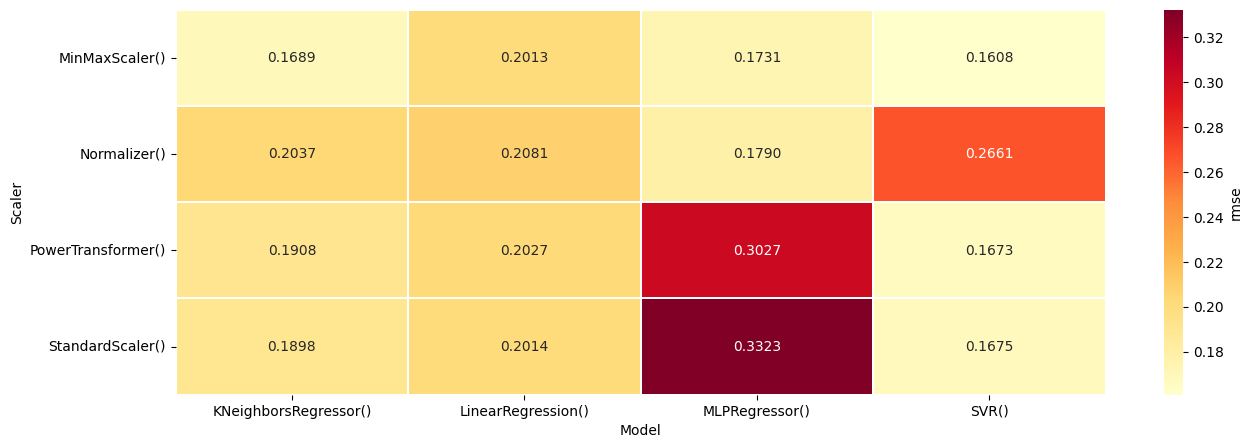

In [26]:
# Heatmap of the models vs. scalers with rmse values
plt.figure(figsize=(15, 5))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt=".4f", linewidths=0.3, cbar_kws={'label': 'rmse'})
plt.xlabel('Model')
plt.ylabel('Scaler')
plt.show()

#### Simple model testing

In [7]:
# Creating dictionary that will hold all preliminary model results
preliminary_testing = {
    "Model": [], 
    "Hyperparameters": [],
    "RVE": [],
    "rmse": [],
    "Pearson's correlation": [],
    "Maximum error": [],
    "Mean absolute error": []
}

# Defining an function to populate the previous dictionary for each model test
def preliminary_results(model=None, stats=None, params="default"):
    if model and stats:
        preliminary_testing["Model"].append(model)
        preliminary_testing["Hyperparameters"].append(params)
        preliminary_testing["RVE"].append(stats[0])
        preliminary_testing["rmse"].append(stats[1])
        preliminary_testing["Pearson's correlation"].append(stats[2])
        preliminary_testing["Maximum error"].append(stats[4])
        preliminary_testing["Mean absolute error"].append(stats[5])
    else:
        print("Please provide a model and the respective performance statistics.")

Decision Trees

In [252]:
dectree = DecisionTreeRegressor()
truth, preds = kfold(dectree, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Decision Tree", stats)

These are the statistics:
The RVE is: 0.32030305465440256
The rmse is: 0.22807352253873658
The Correlation Score is: 0.6599 (p-value=0.000000e+00)

The Maximum Error is: 1.0
The Mean Absolute Error is: 0.15744636794812822


In [27]:
dectree = DecisionTreeRegressor(max_depth=40)
truth, preds = kfold(dectree, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Decision Tree", stats, params="max_depth=40")

These are the statistics:
The RVE is: 0.30961761832357115
The rmse is: 0.2298568139293533
The Correlation Score is: 0.6535 (p-value=0.000000e+00)

The Maximum Error is: 1.0
The Mean Absolute Error is: 0.15873668419700215


K-Nearest Neighbours

In [253]:
knn = KNeighborsRegressor()
truth, preds = kfold(knn, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("K-Nearest Neighbours", stats)

These are the statistics:
The RVE is: 0.6275680282150948
The rmse is: 0.1689419233855493
The Correlation Score is: 0.7934 (p-value=0.000000e+00)

The Maximum Error is: 0.9025431056
The Mean Absolute Error is: 0.12223732262810412


In [280]:
knn15 = KNeighborsRegressor(n_neighbors=15, weights=lambda x: np.exp(-(x**2)/5))
truth, preds = kfold(knn15, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("K-Nearest Neighbours", stats, params="n_neighbors=15, weights=gaussian(kernel_weight=5)")

These are the statistics:
The RVE is: 0.606544739482201
The rmse is: 0.17369540033627942
The Correlation Score is: 0.7886 (p-value=0.000000e+00)

The Maximum Error is: 0.9655843844668794
The Mean Absolute Error is: 0.11962030927442664


Linear Regression

In [ ]:
# Checking how a linear regression fits our model
X_tr = add_constant(X_TRAIN)
mdl = OLS(y_TRAIN, X_tr, hasconst=12).fit()
print(mdl.summary().tables[0])
#print(mdl.summary().tables[1])
print(mdl.summary().tables[2])

                            OLS Regression Results                            
Dep. Variable:     molecular_activity   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     8.426
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:49:11   Log-Likelihood:                 4488.4
No. Observations:                7337   AIC:                            -4719.
Df Residuals:                    5208   BIC:                             9973.
Df Model:                        2128                                         
Covariance Type:            nonrobust                                         
Omnibus:                       82.421   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.873
Skew:                          -0.008   Prob(JB):   

In [255]:
lr = LinearRegression()
truth, preds = kfold(lr, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Linear Regression", stats)

These are the statistics:
The RVE is: 0.47034592126409946
The rmse is: 0.20134014117213955
The Correlation Score is: 0.7190 (p-value=0.000000e+00)

The Maximum Error is: 1.097581783416019
The Mean Absolute Error is: 0.15287227492518127


In [256]:
ridge = Ridge(max_iter=10000)
truth, preds = kfold(ridge, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Ridge", stats)

These are the statistics:
The RVE is: 0.48835724735219743
The rmse is: 0.1978852407005568
The Correlation Score is: 0.7244 (p-value=0.000000e+00)

The Maximum Error is: 1.0658934959964899
The Mean Absolute Error is: 0.15054782099417158


In [257]:
lasso = Lasso(alpha=0.0001, max_iter=10000)
truth, preds = kfold(lasso, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Lasso", stats, params="alpha=0.0001")

These are the statistics:
The RVE is: 0.5770892552274197
The rmse is: 0.17990526939896626
The Correlation Score is: 0.7617 (p-value=0.000000e+00)

The Maximum Error is: 0.9332393458645816
The Mean Absolute Error is: 0.13755103349737624


Support Vector Machines

In [258]:
svr = SVR()
truth, preds = kfold(svr, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Support Vector Machine", stats)

These are the statistics:
The RVE is: 0.6624637533321326
The rmse is: 0.16079090861367407
The Correlation Score is: 0.8172 (p-value=0.000000e+00)

The Maximum Error is: 0.8302717731922313
The Mean Absolute Error is: 0.1235558104029729


In [259]:
svr_tune = SVR(epsilon=0.01, gamma=0.01, max_iter=99999)
truth, preds = kfold(svr_tune, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Support Vector Machine", stats, params="epsilon=0.01, gamma=0.01")

These are the statistics:
The RVE is: 0.6812569004894783
The rmse is: 0.15619149102083502
The Correlation Score is: 0.8256 (p-value=0.000000e+00)

The Maximum Error is: 0.8686262969532121
The Mean Absolute Error is: 0.11328840951972584


Random Forests

In [260]:
rfr = RandomForestRegressor(random_state=13)
truth, preds = kfold(rfr, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Random Forest", stats)

These are the statistics:
The RVE is: 0.6490295445696774
The rmse is: 0.16391843337171944
The Correlation Score is: 0.8076 (p-value=0.000000e+00)

The Maximum Error is: 0.8406636493199999
The Mean Absolute Error is: 0.12206244600723813


In [261]:
rfr40 = RandomForestRegressor(max_depth=40, random_state=13)
truth, preds = kfold(rfr40, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Random Forest", stats, params="max_depth=40")

These are the statistics:
The RVE is: 0.6491194084319709
The rmse is: 0.16389252017549694
The Correlation Score is: 0.8078 (p-value=0.000000e+00)

The Maximum Error is: 0.8337549167642352
The Mean Absolute Error is: 0.12213293420669376


Bagging (Bootstrap Aggregation)

In [262]:
bag_dectree = BaggingRegressor(random_state=13)
truth, preds = kfold(bag_dectree, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Bagging", stats) # 0.60838 0.17316

These are the statistics:
The RVE is: 0.6097152771451483
The rmse is: 0.17285874708775975
The Correlation Score is: 0.7809 (p-value=0.000000e+00)

The Maximum Error is: 0.9109037676
The Mean Absolute Error is: 0.12777252658693053


In [263]:
bag_dectree40 = BaggingRegressor(DecisionTreeRegressor(max_depth=40), random_state=13)
truth, preds = kfold(bag_dectree40, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Bagging", stats, params="estimator=DecisionTreeRegressor(max_depth=40)")

These are the statistics:
The RVE is: 0.6107906669728884
The rmse is: 0.17262183106781595
The Correlation Score is: 0.7816 (p-value=0.000000e+00)

The Maximum Error is: 0.9357897300401089
The Mean Absolute Error is: 0.12800369222538843


In [264]:
bag_knn_tune = BaggingRegressor(KNeighborsRegressor(n_neighbors=15, weights=lambda x: np.exp(-(x**2)/5)), random_state=13)
truth, preds = kfold(bag_knn_tune, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Bagging", stats, params="estimator=KNeighborsRegressor(n_neighbors=15, weights=gaussian(kernel_weight=5))")

These are the statistics:
The RVE is: 0.6399077768652662
The rmse is: 0.16614482989845922
The Correlation Score is: 0.8028 (p-value=0.000000e+00)

The Maximum Error is: 0.9278935348225621
The Mean Absolute Error is: 0.11756813858932315


In [265]:
bag_svr1 = BaggingRegressor(SVR(epsilon=0.01, gamma=0.03, max_iter=99999), random_state=13)
truth, preds = kfold(bag_svr1, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Bagging", stats, params="estimator=SVR(epsilon=0.01, gamma=0.03)")

These are the statistics:
The RVE is: 0.6289835597138193
The rmse is: 0.1685133171916892
The Correlation Score is: 0.8035 (p-value=0.000000e+00)

The Maximum Error is: 0.7924600834252117
The Mean Absolute Error is: 0.12835519587990593


Adaptive Boosting

In [268]:
abr = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=40), random_state=13)
truth, preds = kfold(abr, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Adaptive Boosting", stats, params="estimator=DecisionTreeRegressor(max_depth=40)")

These are the statistics:
The RVE is: 0.6429865364388583
The rmse is: 0.1652984264821481
The Correlation Score is: 0.8019 (p-value=0.000000e+00)

The Maximum Error is: 0.924742501
The Mean Absolute Error is: 0.11855571833425387


In [26]:
abr_svr_tune = AdaBoostRegressor(estimator=SVR(C=0.75, epsilon=0.01, max_iter=99999), n_estimators=30, random_state=13)
truth, preds = kfold(abr_svr_tune, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Adaptive Boosting", stats, params="estimator=SVR(C=0.75, epsilon=0.01), n_estimators=30")

These are the statistics:
The RVE is: 0.6467820349435850
The rmse is: 0.1645789789996832
The Correlation Score is: 0.8028 (p-value=0.000000e+00)
The Maximum Error is: 0.916433477
The Mean Absolute Error is: 0.115395494536676


In [269]:
abr_knn15d = AdaBoostRegressor(estimator=KNeighborsRegressor(n_neighbors=15, weights=lambda x: np.exp(-(x**2))/5), random_state=13)
truth, preds = kfold(abr_knn15d, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Adaptive Boosting", stats, params="estimator=KNeighborsRegressor(n_neighbors=15, weights=gaussian(kernel_weight=5))")

These are the statistics:
The RVE is: 0.5679258988326001
The rmse is: 0.1819767847811521
The Correlation Score is: 0.7688 (p-value=0.000000e+00)

The Maximum Error is: 0.9999995893234466
The Mean Absolute Error is: 0.12303994551047544


Gradient Boosting

In [279]:
gbr = GradientBoostingRegressor(max_depth=40, random_state=13)
truth, preds = kfold(gbr, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Gradient Boosting", stats, params="max_depth=40")

These are the statistics:
The RVE is: 0.479089103472053
The rmse is: 0.19967889950125414
The Correlation Score is: 0.7182 (p-value=0.000000e+00)

The Maximum Error is: 0.9999896854508441
The Mean Absolute Error is: 0.14093074204976389


Extreme Gradient Boosting

In [271]:
xgbr = XGBRegressor()
truth, preds = kfold(xgbr, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Extreme Gradient Boosting", stats)

These are the statistics:
The RVE is: 0.6456308394995283
The rmse is: 0.1646809355624371
The Correlation Score is: 0.8035 (p-value=0.000000e+00)

The Maximum Error is: 0.8174601197242737
The Mean Absolute Error is: 0.12283574714284236


In [278]:
xgbr_tune = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=300)
truth, preds = kfold(xgbr_tune, n_splits=11, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Extreme Gradient Boosting", stats, params="learning_rate=0.1, max_depth=10, n_estimators=300")

These are the statistics:
The RVE is: 0.6683008636826637
The rmse is: 0.15935580466341234
The Correlation Score is: 0.8175 (p-value=0.000000e+00)

The Maximum Error is: 0.9157461002469063
The Mean Absolute Error is: 0.11602286866840246


Multi-layer Perceptrons

In [273]:
mlpr = MLPRegressor(max_iter=10000, random_state=13)
truth, preds = kfold(mlpr, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Multi-layer Perceptron", stats)

These are the statistics:
The RVE is: 0.5917369924542955
The rmse is: 0.17681915014834185
The Correlation Score is: 0.7772 (p-value=0.000000e+00)

The Maximum Error is: 0.941716963252085
The Mean Absolute Error is: 0.1325440444673939


In [274]:
mlpr1 = MLPRegressor(alpha=0.5, hidden_layer_sizes=[50], max_iter=10000, random_state=13)
truth, preds = kfold(mlpr1, n_splits=11)
stats = get_stats(truth, preds)
print_stats(stats)

preliminary_results("Multi-layer Perceptron", stats, params="alpha=0.5, hidden_layer_sizes=[50]")

These are the statistics:
The RVE is: 0.6467361542367001
The rmse is: 0.1644229411169825
The Correlation Score is: 0.8043 (p-value=0.000000e+00)

The Maximum Error is: 0.9106209069517659
The Mean Absolute Error is: 0.1241165908510677


Preliminary results table

In [42]:
# Transforming the results into a dataframe and sorting by the rmse
pd.set_option('display.max_colwidth', 0)
preliminary_testing_df = pd.DataFrame(preliminary_testing)
preliminary_testing_df.sort_values(by=["rmse"], inplace=True)
preliminary_testing_df

,Model,Hyperparameters,RVE,rmse,Pearson's correlation,Maximum error,Mean absolute error
8,Support Vector Machine,"epsilon=0.01, gamma=0.01",0.681257,0.156191,0.8256,0.868626,0.113288
20,Extreme Gradient Boosting,"learning_rate=0.1, max_depth=10, n_estimators=300",0.668301,0.159356,0.8175,0.915746,0.116023
7,Support Vector Machine,default,0.662464,0.160791,0.8172,0.830272,0.123556
10,Random Forest,max_depth=40,0.649119,0.163893,0.8078,0.833755,0.122133
9,Random Forest,default,0.649030,0.163918,0.8076,0.840664,0.122062
22,Multi-layer Perceptron,"alpha=0.5, hidden_layer_sizes=[50]",0.646736,0.164423,0.8043,0.910621,0.124117
16,Adaptive Boosting,"estimator=SVR(C=0.75, epsilon=0.01), n_estimators=30",0.646782,0.164579,0.8028,0.916433,0.115395
19,Extreme Gradient Boosting,default,0.645631,0.164681,0.8035,0.817460,0.122836
15,Adaptive Boosting,estimator=DecisionTreeRegressor(max_depth=40),0.642987,0.165298,0.8019,0.924743,0.118556
13,Bagging,"estimator=KNeighborsRegressor(n_neighbors=15, weights=gaussian(kernel_weight=5))",0.639908,0.166145,0.8028,0.927894,0.117568


#### First tuning of the best models

Support Vector Machines

In [ ]:
param_grid = {
    "C": [0.001, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 50],
    "epsilon": [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.5],
    "gamma": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1]
}

kf = KFold(n_splits=11, shuffle=True, random_state=13)
gs_svr = GridSearchCV(estimator=SVR(max_iter=99999), param_grid=param_grid, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
gs_svr = gs_svr.fit(X_TRAIN, y_TRAIN)

best_params_svr = gs_svr.best_params_
best_mean_test_score_svr = gs_svr.best_score_

In [57]:
print(best_params_svr)
print(best_mean_test_score_svr)

{'C': 1, 'epsilon': 0.025, 'gamma': 0.01}
0.156195


In [ ]:
res = pd.DataFrame(gs_svr.cv_results_)
res = res.sort_values(by=["rank_test_score"])
res[["params", "rank_test_score", "mean_test_score", "std_test_score"]]
# Output for all the grid searches for this work are not shown due to time constraints to repeat the algorithm in this notebook, 
# as they were performed in google colab notebooks or in preliminary python files...

K-Nearest Neighbors

In [8]:
# Defining several lambda functions to work as gaussian weights for KNN
x1 = lambda x: np.exp(-(x**2)/1)
x2 = lambda x: np.exp(-(x**2)/2)
x3 = lambda x: np.exp(-(x**2)/3)
x4 = lambda x: np.exp(-(x**2)/4)
x5 = lambda x: np.exp(-(x**2)/5)
x6 = lambda x: np.exp(-(x**2)/6)
x7 = lambda x: np.exp(-(x**2)/7)
x8 = lambda x: np.exp(-(x**2)/8)
x9 = lambda x: np.exp(-(x**2)/9)
x10 = lambda x: np.exp(-(x**2)/10)
x11 = lambda x: np.exp(-(x**2)/11)
x12 = lambda x: np.exp(-(x**2)/12)
x13 = lambda x: np.exp(-(x**2)/13)
x14 = lambda x: np.exp(-(x**2)/14)
x15 = lambda x: np.exp(-(x**2)/15)
x16 = lambda x: np.exp(-(x**2)/16)
x17 = lambda x: np.exp(-(x**2)/17)
x18 = lambda x: np.exp(-(x**2)/18)
x19 = lambda x: np.exp(-(x**2)/19)
x20 = lambda x: np.exp(-(x**2)/20)

In [ ]:
param_grid = {
    "n_neighbors": [1, 3, 5, 10, 15, 20],
    "weights": ["uniform", "distance", x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20]
}

kf = KFold(n_splits=11, shuffle=True, random_state=13)

gs_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
gs_knn = gs_knn.fit(X_TRAIN, y_TRAIN)

best_params_knn = gs_knn.best_params_
best_mean_test_score_knn = gs_knn.best_score_

In [33]:
print(best_params_knn)
print(best_mean_test_score_knn)

{'n_neighbors': 14, 'weights': <function <lambda> at 0x00000206E5B04860>}
0.161131


In [11]:
for i, x in enumerate([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20]):
  if str(x) == "<function <lambda> at 0x00000206E5B04860>":
    print("kernel weight =", i + 1)

kernel weight = 16


Random Forests

In [ ]:
param = {
    "n_estimators": [25, 50, 100, 150, 200],
    "max_depth": [3, 5, 10, 20, 30, 40, 50]
}

kf = KFold(n_splits=11, shuffle=True, random_state=13)

gs_rfr = GridSearchCV(RandomForestRegressor(random_state=13), param_grid=param, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
gs_rfr = gs_rfr.fit(X_TRAIN, y_TRAIN)

best_params_rfr = gs_rfr.best_params_
best_mean_test_score_rfr = gs_rfr.best_score_

In [54]:
print(best_params_rfr)
print(best_mean_test_score_rfr)

{'max_depth': 40, 'n_estimators': 200}
0.163844


Extreme Gradient Boosting

In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "n_estimators": [10, 20, 50, 100, 200, 250, 300],
    "max_depth": [1, 3, 5, 10, 15, 20],
    "gamma": [0, 0.01, 0.03, 0.05, 0.1]
}

kf = KFold(n_splits=11, shuffle=True, random_state=13)

gs_xgbr = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_xgbr = gs_xgbr.fit(X_TRAIN, y_TRAIN)

best_params_xgbr = gs_xgbr.best_params_
best_mean_test_score_xgbr = gs_xgbr.best_score_

In [55]:
print(best_params_xgbr)
print(best_mean_test_score_xgbr)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
0.159543


Multi-layer Perceptron

In [ ]:
param_grid = {
    "solver": ["adam", "lbfgs", "sgd"],
    "activation": ["relu", "tanh", "logistic", "identity"],
    "hidden_layer_sizes": [[20], [50], [15, 10], [10, 20], [15, 30], [20, 30], [20, 20, 20], [10, 10, 10], [15, 15, 15], [20, 10, 10]],
    "alpha": [0.05, 0.1, 0.25, 0.5, 0.75, 1],
    "tol": [0.001, 0.005, 0.0001, 0.0005, 0.01]
}

kf = KFold(n_splits=11, shuffle=True, random_state=13)

gs_mlpr = GridSearchCV(estimator=MLPRegressor(max_iter=10000, random_state=13), param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_mlpr = gs_mlpr.fit(X_TRAIN, y_TRAIN)

best_params_mlpr = gs_mlpr.best_params_
best_mean_test_score_mlpr = gs_mlpr.best_score_

In [56]:
print(best_params_mlpr)
print(best_mean_test_score_mlpr)

{'activation': 'relu', 'alpha': 0.5, 'hidden_layer_sizes': [15, 10], 'solver': 'adam', 'tol': 0.0001}
0.164422


#### Feature Selection

##### Tuning random forests for feature selection

Hyperparameter tuning

In [ ]:
param = {
    "n_estimators": [10, 20, 30, 50, 75, 100, 150, 200],
    "max_depth": [1, 3, 5, 10, 20, 30, 35, 40, 45, 50, 60],
    "min_samples_leaf": [1, 3, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10, 15, 20]
}

kf = KFold(n_splits=11, shuffle=True, random_state=13)

gs_rfr = GridSearchCV(RandomForestRegressor(random_state=13), param_grid=param, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
gs_rfr = gs_rfr.fit(X_TRAIN, y_TRAIN)

best_params_rfr = gs_rfr.best_params_

In [37]:
print(best_params_rfr)

{'max_depth': 45, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Threshold tuning

In [223]:
# Different threshold values to test
thresholds_to_test = [0.0001, 0.00025, 0.00035, 0.0005, 0.001, 0.005, 0.01, 'mean', 'median']

results = {
    "threshold": [],
    "svr_rmse": [],
    "xgbr_rmse": [],
    "knn_rmse": []
}

rfr = RandomForestRegressor(max_depth=45, n_estimators=225, random_state=13)

# For each threshold, transforms the data and fit the best models
for threshold in thresholds_to_test:
    sel = SelectFromModel(estimator=rfr, threshold=threshold)
    sel.fit(X_TRAIN, y_TRAIN)
    nX_TRAIN = sel.transform(X_TRAIN)
    nX_TRAIN = pd.DataFrame(nX_TRAIN)

    features_selected = np.arange(X_TRAIN.shape[1])[sel.get_support()]
    print(f"Threshold: {threshold} | Number of features selected: {features_selected.shape[0]}")
    
    results["threshold"].append(threshold)

    xgbr_thr = XGBRegressor(learning_rate=0.01, device="cuda:0", colsample_bytree=0.7, subsample=0.8, max_depth=7, n_estimators=3000, objective ="reg:squarederror")
    truth, preds = kfold(xgbr_thr, n_splits=11, nX_TRAIN=nX_TRAIN, scaler=None)
    results["xgbr_rmse"].append(mean_squared_error(truth, preds, squared=False))

    svr_thr = SVR(C=0.8, epsilon=0.025, gamma=0.02, max_iter=99999)
    truth, preds = kfold(svr_thr, n_splits=11, nX_TRAIN=nX_TRAIN)
    results["svr_rmse"].append(mean_squared_error(truth, preds, squared=False))

    knn_thr = KNeighborsRegressor(n_neighbors=14, weights=lambda x: np.exp(-(x**2)/7.5))
    truth, preds = kfold(knn_thr, n_splits=11, nX_TRAIN=nX_TRAIN)
    results["knn_rmse"].append(mean_squared_error(truth, preds, squared=False))

Threshold: 0.0001 | Number of features selected: 1317
Threshold: 0.00025 | Number of features selected: 621
Threshold: 0.00035 | Number of features selected: 454
Threshold: 0.0005 | Number of features selected: 311
Threshold: 0.001 | Number of features selected: 138
Threshold: 0.005 | Number of features selected: 30
Threshold: 0.01 | Number of features selected: 12
Threshold: mean | Number of features selected: 331
Threshold: median | Number of features selected: 1066


In [224]:
svr_test_df = pd.DataFrame(results).groupby(["threshold"])["svr_rmse"].mean().reset_index()
xgbr_test_df = pd.DataFrame(results).groupby(["threshold"])["xgbr_rmse"].mean().reset_index()
knn_test_df = pd.DataFrame(results).groupby(["threshold"])["knn_rmse"].mean().reset_index()

In [232]:
svr_test_df

,threshold,svr_rmse
0,0.0001,0.157162
1,0.00025,0.154745
2,0.00035,0.155327
3,0.0005,0.156237
4,0.001,0.177430
5,0.005,0.234265
6,0.01,0.246022
7,mean,0.155743
8,median,0.155515


In [233]:
xgbr_test_df

,threshold,xgbr_rmse
0,0.0001,0.153835
1,0.00025,0.153441
2,0.00035,0.154187
3,0.0005,0.155861
4,0.001,0.163635
5,0.005,0.187625
6,0.01,0.197451
7,mean,0.154932
8,median,0.153390


In [236]:
knn_test_df

,threshold,knn_rmse
0,0.0001,0.169907
1,0.00025,0.161107
2,0.00035,0.159182
3,0.0005,0.158259
4,0.001,0.174267
5,0.005,0.212803
6,0.01,0.225295
7,mean,0.157934
8,median,0.167475


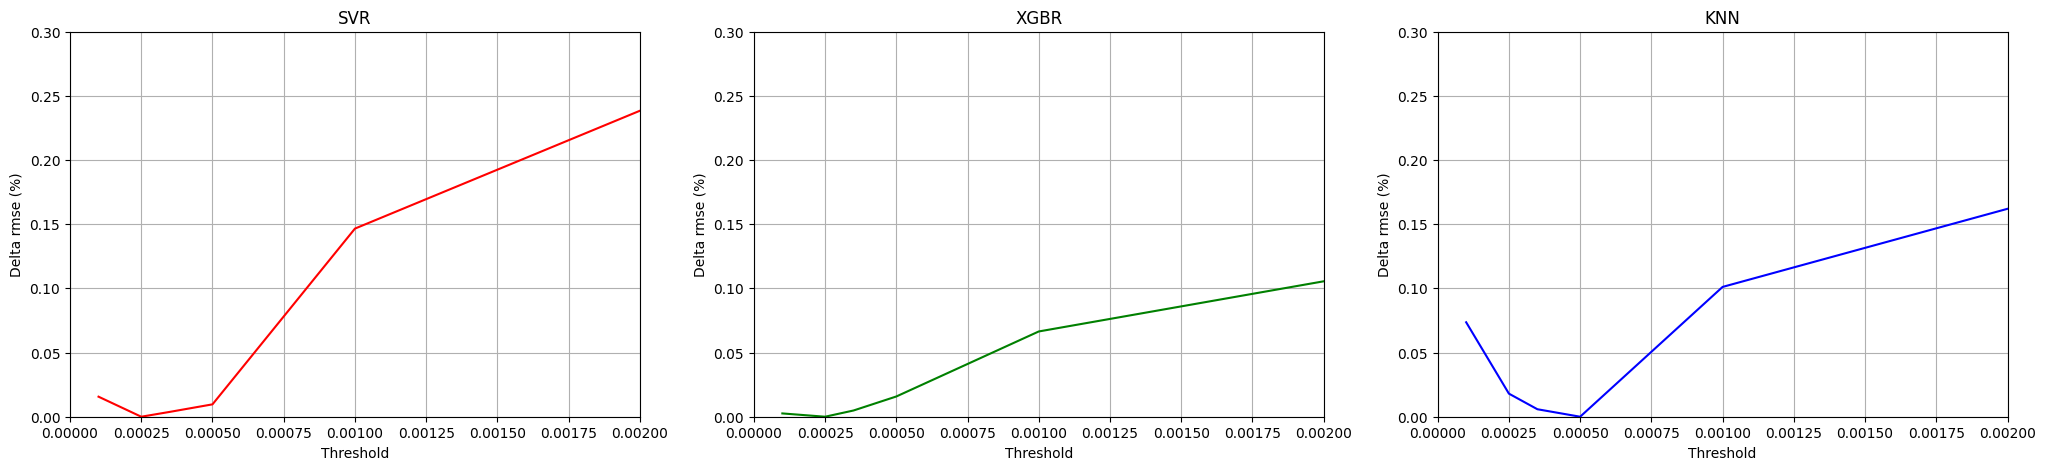

In [241]:
# Plotting the rmse change vs. threshold values
tests = {"svr_rmse": svr_test_df[:-2], "xgbr_rmse": xgbr_test_df[:-2], "knn_rmse": knn_test_df[:-2]}
colors = ["red", "green", "blue"]

plt.figure(figsize=(25, 5))
for i, (k, v) in enumerate(tests.items()):
    plt.subplot(1, 3, i+1)
    pct_increase = (v[k] - min(v[k])) / min(v[k])
    plt.plot(v["threshold"], pct_increase, colors[i])
    plt.xlim(0, 0.002)
    plt.ylim(0, 0.3)
    plt.title(k.replace("_rmse", "").upper())
    plt.xlabel("Threshold")
    plt.ylabel("Delta rmse (%)")
    plt.grid()
plt.show()

#### In-depth hyperparameter tuning the best models taking into account feature selection

In [62]:
# Feature selection
rfr_sel = RandomForestRegressor(max_depth=45, n_estimators=225, random_state=13)
sel = SelectFromModel(rfr_sel, threshold=0.00025)
sel = sel.fit(X_TRAIN, y_TRAIN)

In [200]:
# Number of features retained
features_selected = np.arange(X_TRAIN.shape[1])[sel.get_support()]
features_selected.shape[0]

621

In [63]:
# Transforming the original dataset
nX_TRAIN = sel.transform(X_TRAIN)
nX_IVS = sel.transform(X_IVS)
nX_TRAIN = pd.DataFrame(nX_TRAIN)
nX_IVS = pd.DataFrame(nX_IVS)

Extreme Gradient Boosting

In [ ]:
params = {
    "max_depth": np.arange(1, 21, 2),
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    "n_estimators": [50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

kf = KFold(n_splits=11, shuffle=True, random_state=13)
gs_xgbr = GridSearchCV(XGBRegressor(), param_grid=params, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
gs_xgbr = gs_xgbr.fit(nX_TRAIN, y_TRAIN)

best_params_xgbr = gs_xgbr.best_params_

In [38]:
print(best_params_xgbr)

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 3000, 'subsample': 0.8}


In [202]:
xgbr_tune_sel = XGBRegressor(learning_rate=0.01, device="cuda:0", colsample_bytree=0.7, subsample=0.8, max_depth=7, n_estimators=3000, objective ="reg:squarederror")
truth, preds = kfold(xgbr_tune_sel, n_splits=11, nX_TRAIN=nX_TRAIN, scaler=None)
stats = get_stats(truth, preds)
print_stats(stats)

These are the statistics:
The RVE is: 0.6923969887546519
The rmse is: 0.1534411591969061
The Correlation Score is: 0.8325 (p-value=0.000000e+00)

The Maximum Error is: 0.8519051373004913
The Mean Absolute Error is: 0.11249619968353194


Support Vector Machines

In [ ]:
params = {
    "kernel": ["rbf", "poly", "sigmoid"],
    "C": [0.01, 0.3, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 50],
    "epsilon": [0.0001, 0.0005, 0.001, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.1, 0.5],
    "tol": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}

kf = KFold(shuffle=True, n_splits=11, random_state=13)
gs_svr_sel = GridSearchCV(SVR(max_iter=99999), param_grid=params, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
gs_svr_sel = gs_svr_sel.fit(nX_TRAIN, y_TRAIN)

best_params_svr = gs_svr_sel.best_params_

In [46]:
print(best_params_svr)

{'kernel': 'rbf', 'tol': 0.001, 'C': 1, 'epsilon': 0.025}


In [61]:
svr_tune_sel = SVR(C=0.8, epsilon=0.025, gamma=0.02, max_iter=99999)
truth, preds = kfold(svr_tune_sel, n_splits=11, nX_TRAIN=nX_TRAIN)
stats = get_stats(truth, preds)
print_stats(stats)

These are the statistics:
The RVE is: 0.6900949712072484
The rmse is: 0.1540029864968141
The Correlation Score is: 0.8309 (p-value=0.000000e+00)

The Maximum Error is: 0.9323973902815227
The Mean Absolute Error is: 0.11160149427010432
      


K-Nearest Neighbours

In [47]:
# Defining several lambda functions to work as gaussian weights for KNN
x1 = lambda x: np.exp(-(x**2)/1)
x2 = lambda x: np.exp(-(x**2)/2)
x3 = lambda x: np.exp(-(x**2)/3)
x4 = lambda x: np.exp(-(x**2)/4)
x5 = lambda x: np.exp(-(x**2)/5)
x6 = lambda x: np.exp(-(x**2)/6)
x7 = lambda x: np.exp(-(x**2)/7)
x8 = lambda x: np.exp(-(x**2)/8)
x9 = lambda x: np.exp(-(x**2)/9)
x10 = lambda x: np.exp(-(x**2)/10)

In [ ]:
params = {
    "n_neighbors": np.arange(1, 21),
    "weights": ["uniform", "distance", x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]
}

kf = KFold(n_splits=11, shuffle=True, random_state=13)

gs_knn_sel = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)
gs_knn_sel = gs_knn_sel.fit(nX_TRAIN, y_TRAIN)

best_params_knn = gs_knn_sel.best_params_

In [53]:
print(best_params_knn)

{'n_neighbors': 17, 'weights': <function <lambda> at 0x0000016BDF733D80>}


In [52]:
# Checking which kernel weight the lambda function relates to
for i, x in enumerate([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]):
  if str(x) == "<function <lambda> at 0x0000016BDF733D80>":
    print("kernel weight =", i + 1)

kernel weight = 4


In [204]:
knn_tune_sel = KNeighborsRegressor(n_neighbors=14, weights=lambda x: np.exp(-(x**2)/7.5))
truth, preds = kfold(knn_tune_sel, n_splits=11, nX_TRAIN=nX_TRAIN)
stats = get_stats(truth, preds)
print_stats(stats)

These are the statistics:
The RVE is: 0.6783167277980723
The rmse is: 0.1569167443332566
The Correlation Score is: 0.8237 (p-value=0.000000e+00)

The Maximum Error is: 0.9216531940660795
The Mean Absolute Error is: 0.11362390678118595


Using a voting ensemble method to combine the best models predictions

In [72]:
xgbr_tune_sel = XGBRegressor(learning_rate=0.01, colsample_bytree=0.7, subsample=0.8, max_depth=7, n_estimators=3000, objective ="reg:squarederror")
svr_tune_sel = SVR(C=0.8, epsilon=0.025, gamma=0.02, max_iter=99999)
knn_tune_sel = KNeighborsRegressor(n_neighbors=14, weights=lambda x: np.exp(-(x**2)/7.5))

vtr = VotingRegressor([("knn", knn_tune_sel), ("xgbr", xgbr_tune_sel), ("svr", svr_tune_sel)])
truth, preds = kfold(vtr, n_splits=11, nX_TRAIN=nX_TRAIN)
stats = get_stats(truth, preds)
print_stats(stats)

These are the statistics:
The RVE is: 0.70772157384392
The rmse is: 0.14956667543024657
The Correlation Score is: 0.8416 (p-value=0.000000e+00)

The Maximum Error is: 0.9019852405493645
The Mean Absolute Error is: 0.10842186945062497


Using a stacking ensemble model to combine the best models predictions

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state=13)

str = StackingRegressor([("knn", knn_tune_sel), ("xgbr", xgbr_tune_sel), ("svr", svr_tune_sel)], cv=kf)
truth, preds = kfold(str, n_splits=11, nX_TRAIN=nX_TRAIN)
stats = get_stats(truth, preds)
print_stats(stats)

These are the statistics:
The RVE is: 0.7080349413407199
The rmse is: 0.14947789338551795
The Correlation Score is: 0.8415 (p-value=0.000000e+00)

The Maximum Error is: 0.9076986906502847
The Mean Absolute Error is: 0.10771270224037519


### Final model pipeline

In [67]:
# Load dataset
X_TRAIN, X_IVS, y_TRAIN, col_names = pickle.load(open("drd2_data.pickle", "rb"))
X_TRAIN = pd.DataFrame(X_TRAIN, columns=col_names)
y_TRAIN = pd.Series(y_TRAIN, name="molecular_activity")
X_IVS = pd.DataFrame(X_IVS, columns=col_names)

In [68]:
# Feature selection
rfr_sel = RandomForestRegressor(max_depth=45, n_estimators=225, random_state=13)
sel = SelectFromModel(rfr_sel)
sel = sel.fit(X_TRAIN, y_TRAIN)
nX_TRAIN = sel.transform(X_TRAIN)
nX_IVS = sel.transform(X_IVS)

In [69]:
# Data scaling
scaler = MinMaxScaler()
nX_TRAIN = scaler.fit_transform(nX_TRAIN)
nX_IVS = scaler.transform(nX_IVS)
nX_TRAIN = pd.DataFrame(nX_TRAIN)
nX_IVS = pd.DataFrame(nX_IVS)

In [70]:
# Fitting and predicting best model
xgbr_tune_sel = XGBRegressor(learning_rate=0.01, colsample_bytree=0.7, subsample=0.8, max_depth=7, n_estimators=3000, objective ="reg:squarederror")
svr_tune_sel = SVR(C=0.8, epsilon=0.025, gamma=0.02, max_iter=99999)
knn_tune_sel = KNeighborsRegressor(n_neighbors=14, weights=lambda x: np.exp(-(x**2)/7.5))

kf = KFold(n_splits=11, shuffle=True, random_state=13)

best_model = StackingRegressor([("knn", knn_tune_sel), ("xgbr", xgbr_tune_sel), ("svr", svr_tune_sel)], cv=kf)
best_model = best_model.fit(nX_TRAIN, y_TRAIN)
best_preds = best_model.predict(nX_IVS)

In [71]:
# Saving predictions in a .txt
with open("08.txt", "w") as f:
    np.savetxt(f, best_preds, fmt="%f")

#### Testing other feature selection techniques (PCA and Kernel PCA)

##### PCA

In [43]:
X_TRAIN, X_IVS, y_TRAIN, col_names = pickle.load(open("drd2_data.pickle", "rb"))

In [44]:
scal = MinMaxScaler()
X_TRAIN = scal.fit_transform(X_TRAIN)
X_IVS = scal.transform(X_IVS)
X_TRAIN = pd.DataFrame(X_TRAIN, columns=col_names)
y_TRAIN = pd.Series(y_TRAIN, name="molecular_activity")
X_IVS = pd.DataFrame(X_IVS, columns=col_names)

In [216]:
# Different number of principal components to test
pcs_to_test = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

results = {
    "n_pcs": [],
    "svr_rmse": [],
    "xgbr_rmse": [],
    "knn_rmse": []
}

# For each number of principal components, transforms the data and fit best models
for pc in pcs_to_test:
    pca = PCA(n_components=pc)
    pca = pca.fit(X_TRAIN)
    nX_TRAIN = pca.transform(X_TRAIN)
    nX_IVS = pca.transform(X_IVS)
    nX_TRAIN = pd.DataFrame(nX_TRAIN)
    nX_IVS = pd.DataFrame(nX_IVS)

    results["n_pcs"].append(pc)

    xgbr_thr = XGBRegressor(learning_rate=0.01, device="cuda:0", colsample_bytree=0.7, subsample=0.8, max_depth=7, n_estimators=3000, objective ="reg:squarederror")
    truth, preds = kfold(xgbr_thr, n_splits=11, nX_TRAIN=nX_TRAIN, scaler=None)
    results["xgbr_rmse"].append(mean_squared_error(truth, preds, squared=False))

    svr_thr = SVR(epsilon=0.025, gamma=0.03, max_iter=99999)
    truth, preds = kfold(svr_thr, n_splits=11, nX_TRAIN=nX_TRAIN)
    results["svr_rmse"].append(mean_squared_error(truth, preds, squared=False))

    knn_thr = KNeighborsRegressor(n_neighbors=17, weights=lambda x: np.exp(-(x**2)/4))
    truth, preds = kfold(knn_thr, n_splits=11, nX_TRAIN=nX_TRAIN)
    results["knn_rmse"].append(mean_squared_error(truth, preds, squared=False))

In [217]:
svr_pca_df = pd.DataFrame(results).groupby(["n_pcs"])["svr_rmse"].mean().reset_index()
xgbr_pca_df = pd.DataFrame(results).groupby(["n_pcs"])["xgbr_rmse"].mean().reset_index()
knn_pca_df = pd.DataFrame(results).groupby(["n_pcs"])["knn_rmse"].mean().reset_index()

In [229]:
svr_pca_df

,n_pcs,svr_rmse
0,100,0.204617
1,200,0.186485
2,300,0.176324
3,400,0.171338
4,500,0.168256
5,600,0.165160
6,700,0.163833
7,800,0.162906
8,900,0.163156
9,1000,0.163694


In [230]:
xgbr_pca_df

,n_pcs,xgbr_rmse
0,100,0.169130
1,200,0.168234
2,300,0.168465
3,400,0.169684
4,500,0.170465
5,600,0.171128
6,700,0.172155
7,800,0.172657
8,900,0.173147
9,1000,0.174149


In [231]:
knn_pca_df

,n_pcs,knn_rmse
0,100,0.178226
1,200,0.177205
2,300,0.174707
3,400,0.175455
4,500,0.178002
5,600,0.183690
6,700,0.193010
7,800,0.201383
8,900,0.204984
9,1000,0.210465


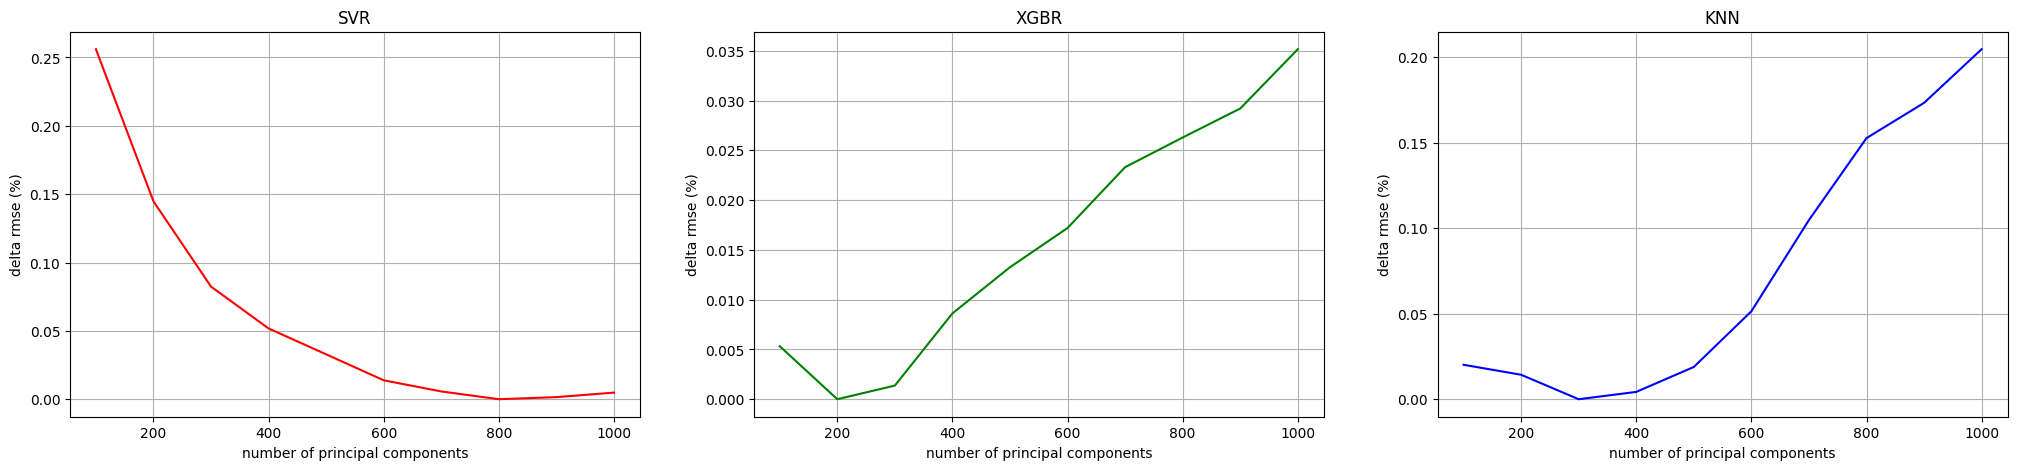

In [ ]:
# Plotting the rmse change vs. number of principal components
tests = {"svr_rmse": svr_pca_df, "xgbr_rmse": xgbr_pca_df, "knn_rmse": knn_pca_df}
colors = ["red", "green", "blue"]

plt.figure(figsize=(25, 10))
for i, (k, v) in enumerate(tests.items()):
    plt.subplot(2, 3, i+1)
    pct_increase = (v[k] - min(v[k])) / min(v[k])
    plt.plot(v["n_pcs"], pct_increase, colors[i])
    plt.axvline(x=800 if k=="svr_rmse" else 200 if k=="xgbr_rmse" else 300, color='black', ls="--")
    plt.title(k.replace("_rmse", "").upper())
    plt.xlabel("Number of principal components")
    plt.ylabel("Delta rmse (%)")
    plt.grid()
plt.show()

In [45]:
# Checking multicollinearity after PCA
pca = PCA(n_components=600)
pca = pca.fit(X_TRAIN)
nX_TRAIN = pca.transform(X_TRAIN)
nX_IVS = pca.transform(X_IVS)
nX_TRAIN = pd.DataFrame(nX_TRAIN)
nX_IVS = pd.DataFrame(nX_IVS)

X_tr = add_constant(nX_TRAIN)
mdl = OLS(y_TRAIN, X_tr, hasconst=12).fit()
print(mdl.summary().tables[0])
#print(mdl.summary().tables[1])
print(mdl.summary().tables[2])

                            OLS Regression Results                            
Dep. Variable:     molecular_activity   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     19.32
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:39:47   Log-Likelihood:                 2689.6
No. Observations:                7337   AIC:                            -4177.
Df Residuals:                    6736   BIC:                            -29.97
Df Model:                         600                                         
Covariance Type:            nonrobust                                         
Omnibus:                      114.977   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.933
Skew:                           0.130   Prob(JB):   

In [46]:
lr_pca = LinearRegression()
truth, preds = kfold(lr_pca, n_splits=11, nX_TRAIN=nX_TRAIN)
print_stats(get_stats(truth, preds))

These are the statistics:
The RVE is: 0.5571237507210917
The rmse is: 0.1840993350527069
The Correlation Score is: 0.7482 (p-value=0.000000e+00)

The Maximum Error is: 0.9455046286060731
The Mean Absolute Error is: 0.1423406142209829


#### Kernel PCA

In [219]:
# Different number of principal components to test
pcs_to_test = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

results = {
    "n_pcs": [],
    "svr_rmse": [],
    "xgbr_rmse": [],
    "knn_rmse": []
}

# For each number of principal components, transforms the data and fit best models
for pc in pcs_to_test:
    kpca = KernelPCA(n_components=pc)
    kpca = kpca.fit(X_TRAIN)
    nX_TRAIN = kpca.transform(X_TRAIN)
    nX_IVS = kpca.transform(X_IVS)
    nX_TRAIN = pd.DataFrame(nX_TRAIN)
    nX_IVS = pd.DataFrame(nX_IVS)

    results["n_pcs"].append(pc)

    xgbr_thr = XGBRegressor(learning_rate=0.01, device="cuda:0", colsample_bytree=0.7, subsample=0.8, max_depth=7, n_estimators=3000, objective ="reg:squarederror")
    truth, preds = kfold(xgbr_thr, n_splits=11, nX_TRAIN=nX_TRAIN, scaler=None)
    results["xgbr_rmse"].append(mean_squared_error(truth, preds, squared=False))

    svr_thr = SVR(epsilon=0.025, gamma=0.03, max_iter=99999)
    truth, preds = kfold(svr_thr, n_splits=11, nX_TRAIN=nX_TRAIN)
    results["svr_rmse"].append(mean_squared_error(truth, preds, squared=False))

    knn_thr = KNeighborsRegressor(n_neighbors=17, weights=lambda x: np.exp(-(x**2)/4))
    truth, preds = kfold(knn_thr, n_splits=11, nX_TRAIN=nX_TRAIN)
    results["knn_rmse"].append(mean_squared_error(truth, preds, squared=False))

In [220]:
svr_kpca_df = pd.DataFrame(results).groupby(["n_pcs"])["svr_rmse"].mean().reset_index()
xgbr_kpca_df = pd.DataFrame(results).groupby(["n_pcs"])["xgbr_rmse"].mean().reset_index()
knn_kpca_df = pd.DataFrame(results).groupby(["n_pcs"])["knn_rmse"].mean().reset_index()

In [226]:
svr_kpca_df

,n_pcs,svr_rmse
0,100,0.204509
1,200,0.185935
2,300,0.177028
3,400,0.171390
4,500,0.168351
5,600,0.165583
6,700,0.163704
7,800,0.162981
8,900,0.163169
9,1000,0.163650


In [227]:
xgbr_kpca_df

,n_pcs,xgbr_rmse
0,100,0.169310
1,200,0.167890
2,300,0.168642
3,400,0.169180
4,500,0.169951
5,600,0.171104
6,700,0.172151
7,800,0.172500
8,900,0.173101
9,1000,0.174096


In [228]:
knn_kpca_df

,n_pcs,knn_rmse
0,100,0.178457
1,200,0.176901
2,300,0.174910
3,400,0.175314
4,500,0.177611
5,600,0.182671
6,700,0.191938
7,800,0.200241
8,900,0.204906
9,1000,0.209489


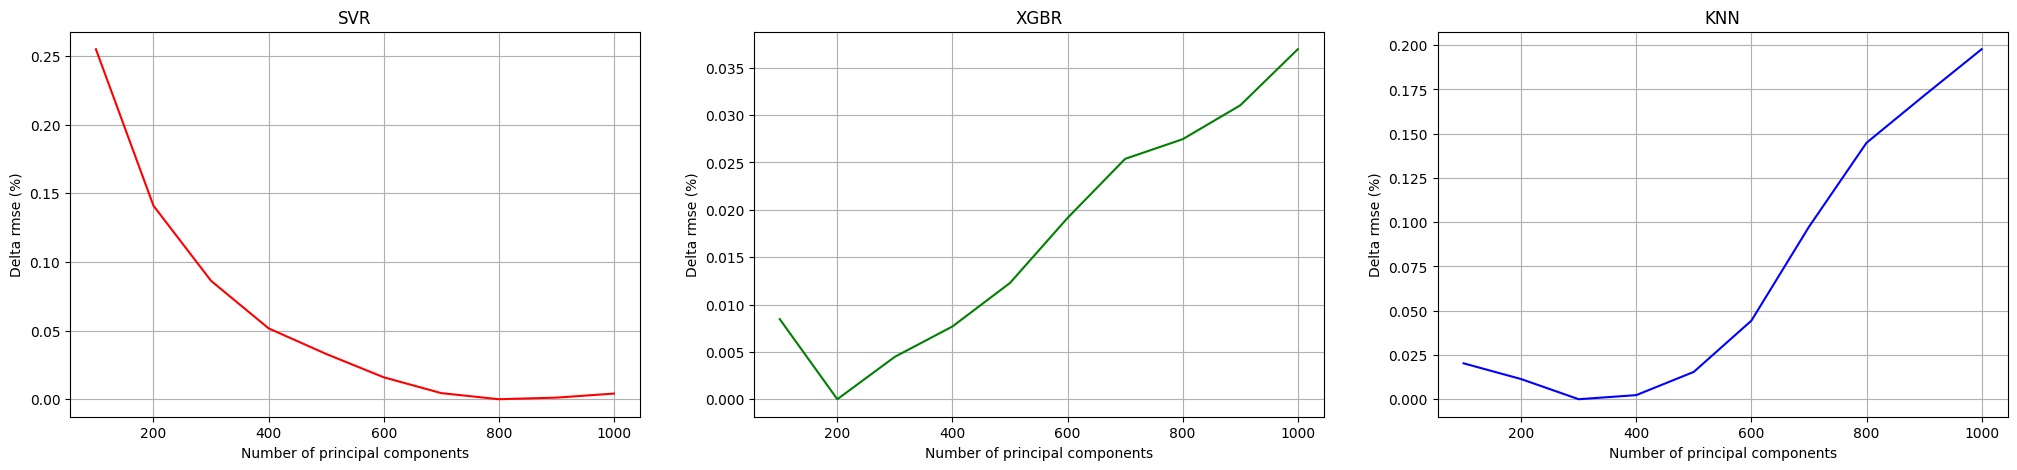

In [221]:
# Plotting the rmse change vs. number of principal components
tests = {"svr_rmse": svr_kpca_df, "xgbr_rmse": xgbr_kpca_df, "knn_rmse": knn_kpca_df}
colors = ["red", "green", "blue"]

plt.figure(figsize=(25, 5))
for i, (k, v) in enumerate(tests.items()):
    plt.subplot(1, 3, i+1)
    pct_increase = (v[k] - min(v[k])) / min(v[k])
    plt.plot(v["n_pcs"], pct_increase, colors[i])
    plt.title(k.replace("_rmse", "").upper())
    plt.xlabel("Number of principal components")
    plt.ylabel("Delta rmse (%)")
    plt.grid()
plt.show()

In [47]:
# Checking multicollinearity after Kernel PCA
kpca = KernelPCA(n_components=600)
kpca = kpca.fit(X_TRAIN)
nX_TRAIN = pca.transform(X_TRAIN)
nX_IVS = pca.transform(X_IVS)
nX_TRAIN = pd.DataFrame(nX_TRAIN)
nX_IVS = pd.DataFrame(nX_IVS)

X_tr = add_constant(nX_TRAIN)
mdl = OLS(y_TRAIN, X_tr, hasconst=12).fit()
print(mdl.summary().tables[0])
#print(mdl.summary().tables[1])
print(mdl.summary().tables[2])

                            OLS Regression Results                            
Dep. Variable:     molecular_activity   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     19.32
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:40:29   Log-Likelihood:                 2689.6
No. Observations:                7337   AIC:                            -4177.
Df Residuals:                    6736   BIC:                            -29.97
Df Model:                         600                                         
Covariance Type:            nonrobust                                         
Omnibus:                      114.977   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.933
Skew:                           0.130   Prob(JB):   

In [48]:
lr_kpca = LinearRegression()
truth, preds = kfold(lr_kpca, n_splits=11, nX_TRAIN=nX_TRAIN)
print_stats(get_stats(truth, preds))

These are the statistics:
The RVE is: 0.5571237507210917
The rmse is: 0.1840993350527069
The Correlation Score is: 0.7482 (p-value=0.000000e+00)

The Maximum Error is: 0.9455046286060731
The Mean Absolute Error is: 0.1423406142209829
